# Data Exploration

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import warnings

# NWP/RTMA
import pygrib
# Radiosondes
import metpy.calc as mpcalc
from metpy.plots import SkewT, Hodograph
from metpy.units import units
# GOES
from netCDF4 import Dataset

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
vol = '/Users/stock/Development/research/soundings/data/subset/'

## GOES

In [3]:
def convert_rad_tb(g16nc):
    rad_fnc = g16nc.variables['Rad'][:,:]   # Read unscaled radiances; converted to scaled
                                            # Radiances units: mW m-2 sr-1 (cm-1)-1
    fk1 = g16nc.variables['planck_fk1'][0]  # Constants to convert Rad to Tb
    fk2 = g16nc.variables['planck_fk2'][0]
    bc1 = g16nc.variables['planck_bc1'][0]
    bc2 = g16nc.variables['planck_bc2'][0]

    # Convert Scaled Radiances to Tbs
    data = (fk2 / np.log((fk1 / rad_fnc) + 1.0) - bc1) / bc2 # Here tb is a masked array
                                                             # Replace all values where 
    # data = tb_masked.filled(-999.)                         # np.ma.getmaskarray(tb_masked) == True
    # TODO: check which units we want things in
    data = rad_fnc

    return data


def convert_angle_geodetic(g16nc, proj_info):
    """
    Navigating from N/S Elevation Angle (y) and E/W Scanning Angle (x)
    to Geodetic Latitude (φ) and Longitude (λ)
    Equations from https://www.goes-r.gov/users/docs/PUG-L1b-vol3.pdf
    """
    # GOES-R projection info and retrieving relevant constants
    lon_origin = proj_info.longitude_of_projection_origin
    H = proj_info.perspective_point_height+proj_info.semi_major_axis
    r_eq = proj_info.semi_major_axis
    r_pol = proj_info.semi_minor_axis

    # grid info
    lat_rad_1d = g16nc.variables['x'][:]
    lon_rad_1d = g16nc.variables['y'][:]

    # create meshgrid filled with radian angles
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)

    # lat/lon calc routine from satellite radian angle vectors

    lambda_0 = (lon_origin*np.pi)/180.0

    a_var = np.sin(lat_rad)**2 + (np.cos(lat_rad)**2 * (np.cos(lon_rad)**2 + (((r_eq**2)/(r_pol**2))*np.sin(lon_rad)**2)))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)

    # np.any((b_var**2)-(4.0*a_var*c_var) == 0)
    # error due to zero values
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        r_s = (- b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        lat = (180.0/np.pi)* np.arctan(((r_eq**2)/(r_pol**2)) * (s_z / np.sqrt((H-s_x)**2 + s_y**2)))
    lon = (180.0/np.pi)*(lambda_0 - np.arctan(s_y/(H-s_x)))

    return lat_rad_1d, lon_rad_1d, lat, lon
    

def read_region(fin):
    data = None
    g16nc = Dataset(fin, 'r')
        
    try:
        band_id = g16nc.variables['band_id'][:]
        band_wavelength = g16nc.variables['band_wavelength']
        band_wavelength_units = band_wavelength.units
    except:
        band_id = -1
        band_wavelength = -1
        band_wavelength_units = ''
    
    if ( 7 <= band_id[0] and band_id[0] <= 16 ):
        data = convert_rad_tb(g16nc)
    
    proj_info = g16nc.variables['goes_imager_projection']

    lat_rad_1d, lon_rad_1d, lat, lon = convert_angle_geodetic(g16nc, proj_info)
    
    central_lon = proj_info.longitude_of_projection_origin
    
    h = proj_info.perspective_point_height
    x = lat_rad_1d * h 
    y = lon_rad_1d * h
    
    g16nc.close()
    return {'data': data,
            'central_lon': central_lon,
            'h': h, 'x': x, 'y': y,
            'lat': lat, 'lon': lon}


def plot_region(D, plate_carree=False):
    geos = ccrs.Geostationary(central_longitude=D['central_lon'], 
                              satellite_height=D['h'])

    fig = plt.figure(figsize=(12, 6))
    if plate_carree:
        proj = ccrs.PlateCarree(central_longitude=D['central_lon'])
    else:
        proj = geos
    # create axis with Geostationary projection
    ax = fig.add_subplot(111, projection=proj)

    im = ax.imshow(D['data'], origin='upper', cmap='RdYlBu_r',
                   extent=(D['x'].min(), D['x'].max(), D['y'].min(), D['y'].max()),
                   transform=geos)

    ax.coastlines(resolution='50m', color='black', linewidth=0.25)
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)
    
    if plate_carree:
        ax.set_extent([D['lon'].min(), D['lon'].max(), D['lat'].min(), D['lat'].max()])
        
    fig.colorbar(im)

    plt.show()
    
    
def lat_lon_point(D, lat=40.5853, lon=-105.0844):
    # Compute the abosulte difference between the grid lat/lon and the point
    abslat = np.abs(D['lat']-lat)
    abslon = np.abs(D['lon']-lon)

    # Element-wise maxima
    c = np.maximum(abslon, abslat)

    # The index of the minimum maxima (which is the nearest lat/lon)
    x, y = np.where(c == np.min(c))
    
    return x[0], y[0]

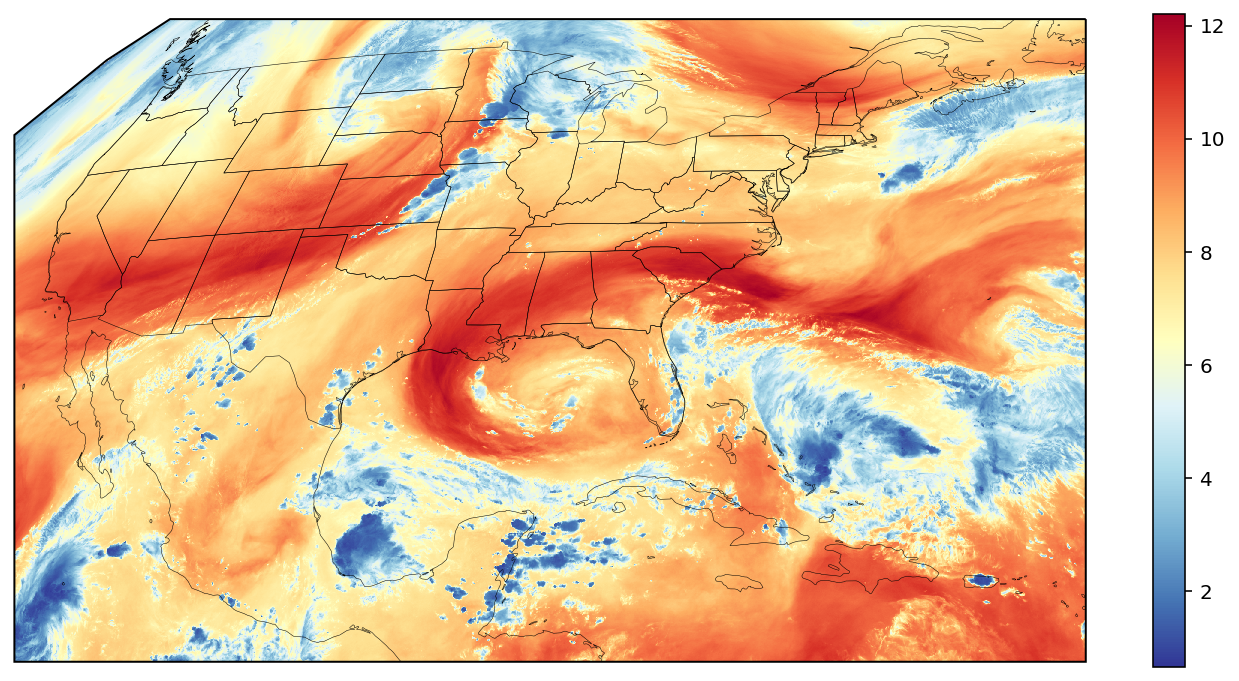

In [4]:
fin = vol + 'goes/OR_ABI-L1b-RadC-M6C09_G16_s20192551901134_e20192551903513_c20192551903580.nc'
D = read_region(fin)
plot_region(D)

## NWP

`grib2` required to read files, install with:

In [5]:
def read_grb_index(fin, idx=1):
    grbs = pygrib.open(fin)
    
    value, lat, lon = grbs[idx].data()
    validDATE = grbs[idx].validDate
    anlysDATE = grbs[idx].analDate
    msg = grbs[idx]
    name = grbs[idx].parameterName
    
    grbs.close()
    return {'value': value,
            'lat': lat,
            'lon': lon,
            'valid': validDATE,
            'anlys': anlysDATE,
            'msg':msg,
            'name': name}


def plot_grb(D):
    plt.figure(1)
    plt.pcolormesh(D['lon'], D['lat'], D['value'], cmap='Spectral_r')
    plt.colorbar()
    plt.title(f"{D['name']}, valid: {D['valid']}")
    plt.ylabel('latitude'), plt.xlabel('longitude')

### RAP Model

In [7]:
fin = vol + 'nwp_model/rap_130_20190912_1900_000.grb2'

- codedValues vs latLonValues (with latitudes & longitudes)

Time units
- significanceOfReferenceTime
- dataTime
- forecastTime
- indicatorOfUnitOfTimeRange
- validityTime

Multiple Vertical velocity (pressure) parameter names with differences in isobaric InhPa levels

In [8]:
data = pygrib.open(fin)

In [9]:
for geo1, geo2 in zip(data[10:11], data[191:192]):
    for k1, k2 in zip(geo1.keys(), geo2.keys()):
        print(f'{k1}: {getattr(geo1, k1)} | {k2}: {getattr(geo2, k2)}')

globalDomain: g | globalDomain: g
GRIBEditionNumber: 2 | GRIBEditionNumber: 2
tablesVersionLatest: 23 | tablesVersionLatest: 23
grib2divider: 1000000 | grib2divider: 1000000
is_efas: 0 | is_efas: 0
angleSubdivisions: 1000000 | angleSubdivisions: 1000000
missingValue: 9999 | missingValue: 9999
ieeeFloats: 1 | ieeeFloats: 1
isHindcast: 0 | isHindcast: 0
section0Length: 16 | section0Length: 16
identifier: GRIB | identifier: GRIB
discipline: 0 | discipline: 0
editionNumber: 2 | editionNumber: 2
totalLength: 12647 | totalLength: 42502
sectionNumber: [1 3 3 4 5 6 7] | sectionNumber: [1 3 3 4 5 6 7]
section1Length: 21 | section1Length: 21
numberOfSection: [1 3 4 5 6 7] | numberOfSection: [1 3 4 5 6 7]
centre: kwbc | centre: kwbc
centreDescription: US National Weather Service - NCEP | centreDescription: US National Weather Service - NCEP
subCentre: 0 | subCentre: 0
tablesVersion: 2 | tablesVersion: 2
masterDir: grib2/tables/[tablesVersion] | masterDir: grib2/tables/[tablesVersion]
localTablesV

paramIdECMF: 135 | paramIdECMF: 135
paramId: 135 | paramId: 135
shortNameECMF: w | shortNameECMF: w
shortName: w | shortName: w
unitsECMF: Pa s**-1 | unitsECMF: Pa s**-1
units: Pa s**-1 | units: Pa s**-1
nameECMF: Vertical velocity | nameECMF: Vertical velocity
name: Vertical velocity | name: Vertical velocity
cfNameECMF: lagrangian_tendency_of_air_pressure | cfNameECMF: lagrangian_tendency_of_air_pressure
cfName: lagrangian_tendency_of_air_pressure | cfName: lagrangian_tendency_of_air_pressure
cfVarNameECMF: w | cfVarNameECMF: w
cfVarName: w | cfVarName: w
modelName: unknown | modelName: unknown
ifsParam: 135 | ifsParam: 135
PVPresent: 0 | PVPresent: 0
deletePV: 1 | deletePV: 1
md5Section4: 03f023b00a062531f99e1f5352b330c8 | md5Section4: c0c54bd9339aa5801fd7b2228e8bfc9b
lengthOfHeaders: 136 | lengthOfHeaders: 136
md5Headers: 2c582448639b9070b849a4e672b93879 | md5Headers: 3e023699e6c09989125e513357c30e93
sectionNumber: [1 3 3 4 5 6 7] | sectionNumber: [1 3 3 4 5 6 7]
section5Length: 23

In [10]:
for i, grb in enumerate(data[:]):
    print(f'{i}: {grb.parameterName}')

0: 196
1: Visibility
2: 195
3: 195
4: Geopotential height
5: Wind speed [gust]
6: 3
7: Geopotential height
8: Temperature
9: Relative humidity
10: Vertical velocity [pressure]
11: u-component of wind
12: v-component of wind
13: Geopotential height
14: Temperature
15: Relative humidity
16: Vertical velocity [pressure]
17: u-component of wind
18: v-component of wind
19: Geopotential height
20: Temperature
21: Relative humidity
22: Vertical velocity [pressure]
23: u-component of wind
24: v-component of wind
25: Geopotential height
26: Temperature
27: Relative humidity
28: Vertical velocity [pressure]
29: u-component of wind
30: v-component of wind
31: Geopotential height
32: Temperature
33: Relative humidity
34: Vertical velocity [pressure]
35: u-component of wind
36: v-component of wind
37: Geopotential height
38: Temperature
39: Relative humidity
40: Vertical velocity [pressure]
41: u-component of wind
42: v-component of wind
43: Geopotential height
44: Temperature
45: Relative humidity

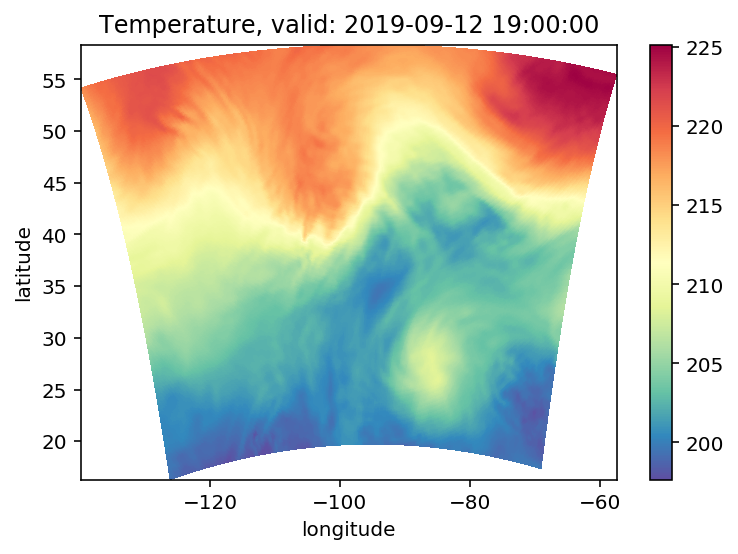

In [11]:
D = read_grb_index(fin, 15)
plot_grb(D)

### HRRR Model

In [12]:
fin = vol + 'nwp_model/hrrr.t19z.wrfprsf00.grib2'

In [13]:
data = pygrib.open(fin)

In [14]:
for grb in data[:1]:
    for k in grb.keys():
        print(f'{k}: {getattr(grb, k)}')

globalDomain: g
GRIBEditionNumber: 2
tablesVersionLatest: 23
grib2divider: 1000000
is_efas: 0
angleSubdivisions: 1000000
missingValue: 9999
ieeeFloats: 1
isHindcast: 0
section0Length: 16
identifier: GRIB
discipline: 0
editionNumber: 2
totalLength: 714190
sectionNumber: [1 3 3 4 5 6 7]
section1Length: 21
numberOfSection: [1 3 4 5 6 7]
centre: kwbc
centreDescription: US National Weather Service - NCEP
subCentre: 0
tablesVersion: 2
masterDir: grib2/tables/[tablesVersion]
localTablesVersion: 1
significanceOfReferenceTime: 1
year: 2018
month: 4
day: 23
hour: 19
minute: 0
second: 0
dataDate: 20180423
julianDay: 2458232.2916666665
dataTime: 1900
productionStatusOfProcessedData: 0
typeOfProcessedData: fc
md5Section1: 9588bc24d5da4b128de683049f7cee83
selectStepTemplateInterval: 1
selectStepTemplateInstant: 1
stepType: instant
is_chemical: 0
is_chemical_distfn: 0
is_aerosol: 0
is_aerosol_optical: 0
setCalendarId: 0
deleteCalendarId: 0
is_uerra: 0
sectionNumber: [1 3 3 4 5 6 7]
grib2LocalSectionP

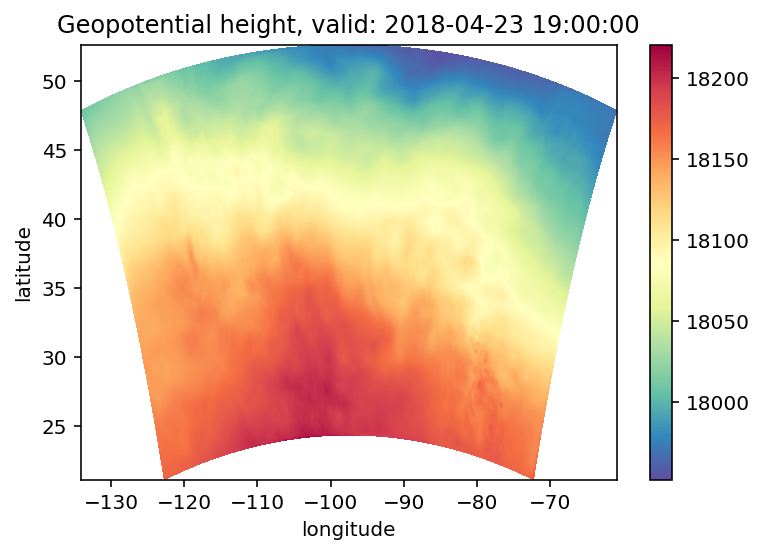

In [15]:
D = read_grb_index(fin, 15)
plot_grb(D)

## RTMA

### Surface Pressure

In [16]:
fin = vol + 'rtma/9950_NDGD_LPI_20190912/LPIA98_KWBR_201909120300'

In [17]:
grbs = pygrib.open(fin)
for i in range(grbs.messages):
    if i > 10: break;
    print(grbs[i+1])

1:Surface pressure:Pa (instant):lambert:surface:level 0:fcst time 0 hrs:from 201909120300
2:Surface pressure:Pa (instant):lambert:surface:level 0:fcst time 0 hrs:from 201909120300


In [18]:
# show fields
for k in data[:1][0].keys():
    print(f'{k}: {getattr(grb, k)}')

globalDomain: g
GRIBEditionNumber: 2
tablesVersionLatest: 23
grib2divider: 1000000
is_efas: 0
angleSubdivisions: 1000000
missingValue: 9999
ieeeFloats: 1
isHindcast: 0
section0Length: 16
identifier: GRIB
discipline: 0
editionNumber: 2
totalLength: 714190
sectionNumber: [1 3 3 4 5 6 7]
section1Length: 21
numberOfSection: [1 3 4 5 6 7]
centre: kwbc
centreDescription: US National Weather Service - NCEP
subCentre: 0
tablesVersion: 2
masterDir: grib2/tables/[tablesVersion]
localTablesVersion: 1
significanceOfReferenceTime: 1
year: 2018
month: 4
day: 23
hour: 19
minute: 0
second: 0
dataDate: 20180423
julianDay: 2458232.2916666665
dataTime: 1900
productionStatusOfProcessedData: 0
typeOfProcessedData: fc
md5Section1: 9588bc24d5da4b128de683049f7cee83
selectStepTemplateInterval: 1
selectStepTemplateInstant: 1
stepType: instant
is_chemical: 0
is_chemical_distfn: 0
is_aerosol: 0
is_aerosol_optical: 0
setCalendarId: 0
deleteCalendarId: 0
is_uerra: 0
sectionNumber: [1 3 3 4 5 6 7]
grib2LocalSectionP

In [19]:
dat = {}

d1 = grbs[0:1][0]
for k in d1.keys():
    dat[k] = getattr(d1, k)

d2 = grbs[1:2][0]
for k in d2.keys():
    d = getattr(d2, k)
    flagged = False
    if isinstance(d, (list, np.ndarray)):
        if (d != dat[k]).all():
            flagged = True    
    elif d != dat[k]:
        flagged = True
        
    if flagged:
        print(f'{k}; {dat[k]} | {d}')

totalLength; 5907518 | 5169102
typeOfGeneratingProcess; 0 | 7
md5Section4; fded2b2319ae6a0834c5af63accb00e2 | 0cf0104a0ed18865858e7bc6dc5cde1a
md5Headers; 50ba3e1a98115f7fa6be9633a80fdf76 | da1472805ad18abeddc8f0ea4a850731
referenceValue; 61194.0 | 5733.0
referenceValueError; 0.00390625 | 0.00048828125
decimalScaleFactor; 0 | 2
bitsPerValue; 16 | 14
md5Section5; c4827ae708fbf93f28a59d05082cc320 | d282d5b6733d8003447999ca1ffe73be
section7Length; 5907335 | 5168919
codedValues; [101338. 101339. 101340. ... 101553. 101553. 101551.] | [140.88 140.88 140.88 ... 138.51 138.54 138.56]
values; [[101338. 101339. 101340. ... 101242. 101242. 101242.]
 [101341. 101341. 101340. ... 101242. 101242. 101242.]
 [101342. 101342. 101341. ... 101242. 101242. 101242.]
 ...
 [101134. 101197. 101197. ... 101550. 101551. 101551.]
 [101132. 101196. 101196. ... 101551. 101551. 101551.]
 [101129. 101195. 101196. ... 101553. 101553. 101551.]] | [[140.88 140.88 140.88 ... 140.88 140.88 140.88]
 [140.88 140.88 140.8

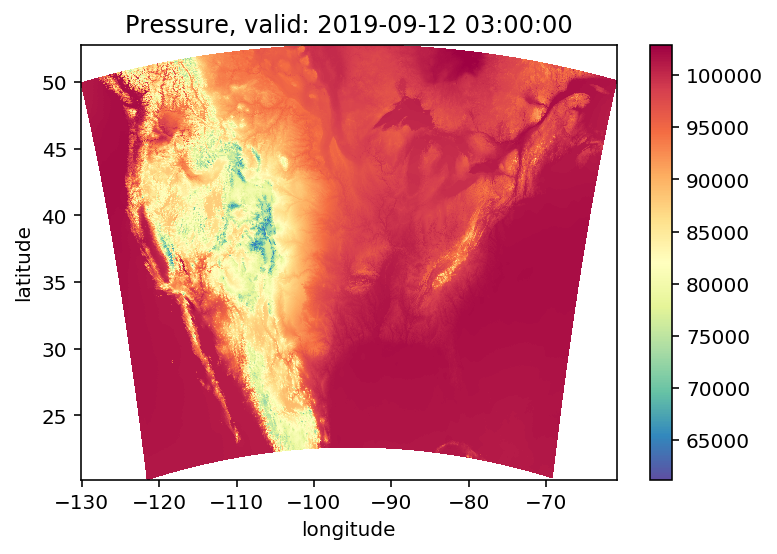

In [20]:
# index of true values
D = read_grb_index(fin, 1)
plot_grb(D)

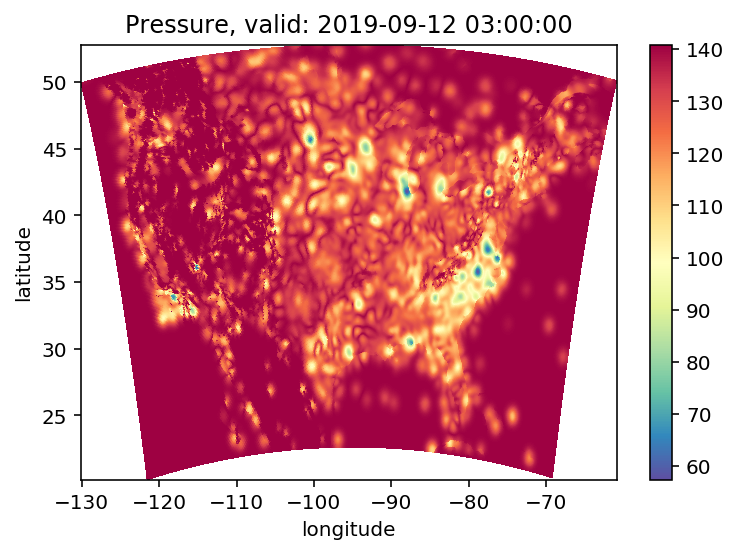

In [21]:
# index of error values
D = read_grb_index(fin, 2)
plot_grb(D)

### Surface Temperature

In [22]:
fin = vol + 'rtma/9950_NDGD_LTI_20190912/LTIA98_KWBR_201909120300'

In [23]:
grbs = pygrib.open(fin)
for i in range(grbs.messages):
    if i > 10: break;
    print(grbs[i+1])

1:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201909120300
2:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201909120300


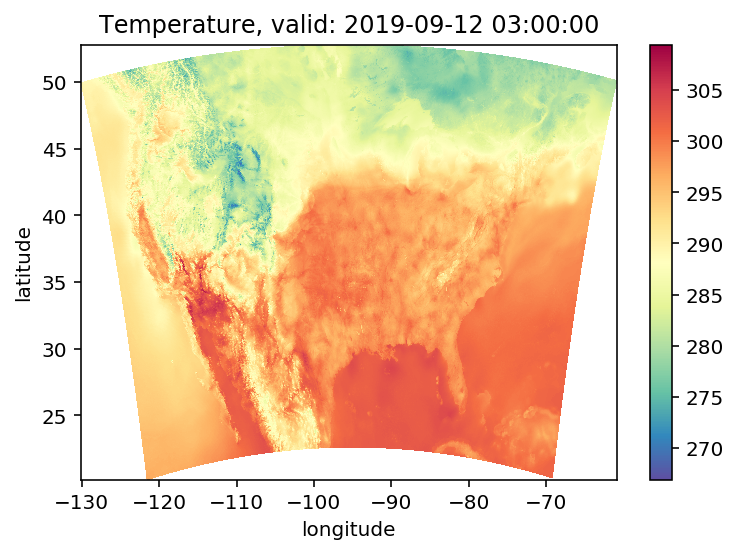

In [24]:
# index of true values
D = read_grb_index(fin, 1)
plot_grb(D)

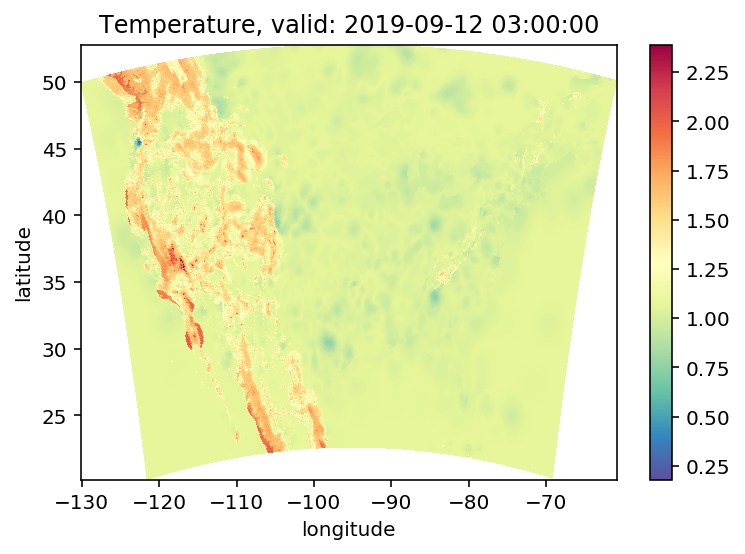

In [25]:
# index of error values
D = read_grb_index(fin, 2)
plot_grb(D)

### Surface Dewpoint Temperature

In [26]:
fin = vol + 'rtma/9950_NDGD_LRI_20190912/LRIA98_KWBR_201909120300'

In [27]:
grbs = pygrib.open(fin)
for i in range(grbs.messages):
    if i > 10: break;
    print(grbs[i+1])

1:2 metre dewpoint temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201909120300
2:2 metre dewpoint temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 hrs:from 201909120300


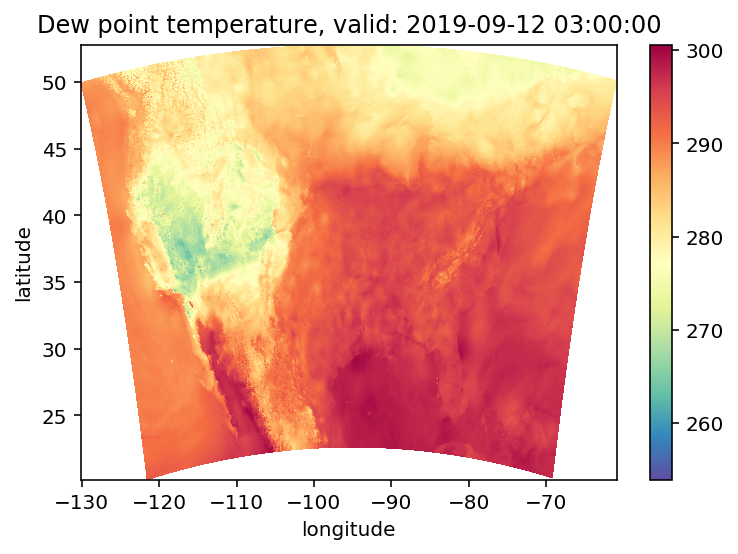

In [28]:
# index of true values
D = read_grb_index(fin, 1)
plot_grb(D)

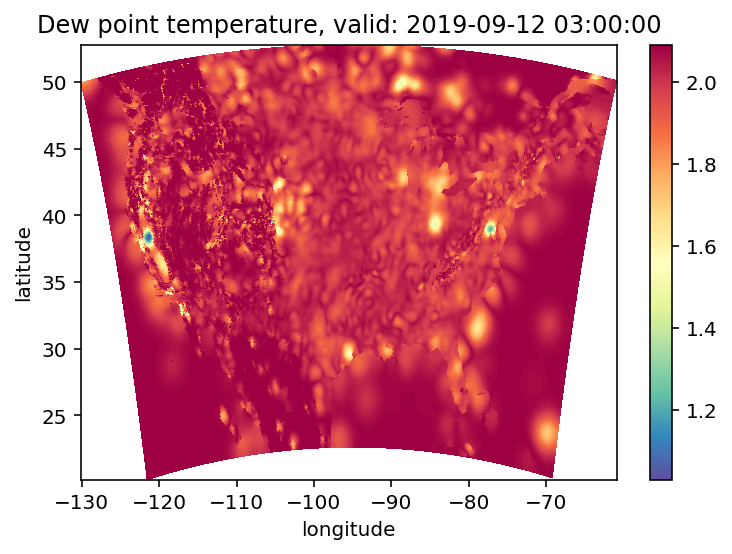

In [29]:
# index of error values
D = read_grb_index(fin, 2)
plot_grb(D)

## Radiosonde

The official FSL data format is similar to the format used by the National
Severe Storms Forecast Center (NSSFC) in Kansas City.  The first 4 lines of 
the sounding are identification and information lines. All additional lines 
are data lines.  An entry of 32767 (original format) or 99999 (new format) 
indicates that the information is either missing, not reported, or not 
applicable.

In [30]:
fin = vol + '/radiosonde/20190912.dat'

In [ ]:
col_names = ['LINTYP', 'PRESSURE', 'HEIGHT', 'TEMP', 
             'DEWPT', 'WINDDIR', 'WINDSPD']

data = pd.read_csv(fin, sep='\s+', names=col_names)

In [ ]:
experiments = []

dfs = np.split(data, np.where(data.LINTYP == 254)[0])[1:]

for d in dfs:
    split = np.split(d, np.where(d.LINTYP == 9)[0])
    # change column names from metadata
    split[0].columns = range(split[0].shape[1])
    split[0].reset_index(drop=True, inplace=True)
    
    # remove missing info form data
    split[1] = split[1].apply(pd.to_numeric)
    # TODO: repalce with previous value from series, do not drop.
    split[1] = split[1][(split[1].PRESSURE != 99999) 
                      & (split[1].HEIGHT != 99999) 
                      & (split[1].DEWPT != 99999) 
                      & (split[1].TEMP != 99999)].reset_index(drop=True)

    split[1].WINDDIR.replace([99999, 32767], 0, inplace=True)
    split[1].WINDSPD.replace([99999, 32767], 0, inplace=True)
    
    # convert tenths of units to unit
    split[1][['PRESSURE','TEMP', 
              'DEWPT']] = split[1][['PRESSURE','TEMP', 
                                    'DEWPT']].div(10., axis=0)
    
    experiments.append({'metadata': split[0], 'data': split[1]})

In [ ]:
i = 2

df = experiments[i]['data']

smallest = df[df.PRESSURE < 100].index

if len(smallest) > 0:
    smallest = smallest[0]
else:
    smallest = len(df)

p = df['PRESSURE'].values[:smallest] * units.hPa
T = df['TEMP'].values[:smallest] * units.degC
Td = df['DEWPT'].values[:smallest] * units.degC
wind_speed = df['WINDSPD'].values[:smallest] * units.knots
wind_dir = df['WINDDIR'].values[:smallest] * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

In [51]:
def read_radiosonde(fin):
    """
    Read in a .dat FSL Rawinsonde data file/
    input:
        fin: file input name
    output:
        [{'metadata' {...}, 'data': {...}}, ...]
    """
    cols = {254: (('HOUR', 7, 14), ('DAY', 14, 21), ('MONTH', 21, 30), ('YEAR', 30, 38)),
            1: (('WBAN', 7, 14), ('WMO', 14, 21), ('LAT', 21, 29),
                ('LON', 29, 36), ('ELEV', 36, 42), ('RTIME', 42, 49)),
            2: (('HYDRO', 7, 14), ('MXWD', 14, 21), ('TROPL', 21, 28), 
                ('LINES', 28, 35), ('TINDEX', 35, 42), ('SOURCE', 42, 49)),
            3: (('STAID', 17, 21), ('SONDE', 37, 42), ('WSUNITS', 42, 49))}

    dflt = (('PRESSURE', 7, 14), ('HEIGHT', 14, 21), ('TEMP', 21, 28), 
            ('DEWPT', 28, 35), ('WINDDIR', 35, 42), ('WINDSPD', 42, 49))

    experiments = []

    with open(fin, 'r') as f:
        def build_dict(LINTYP, dictionary, validate_data=False):
            for name, beg, end in cols.get(LINTYP, dflt):
                value = line[beg:end].strip()
                if validate_data:
                    value = int(value)
                    # remove missing values and those below 100 hPa
                    # convert tenths to whole units
                    if name in ['TEMP', 'DEWPT']:
                        if value == 99999:
                            return False
                        value /= 10.
                    if name in ['WINDSPD', 'WINDDIR']:
                        if value == 99999:
                            value = 0
                    if name in ['PRESSURE']:
                        if value < 1000:
                            return False
                        value /= 10.
                dictionary[name] = value
            return True

        for i, line in enumerate(f):
            LINTYP = int(line[:7])

            if LINTYP == 254:
                if i != 0:
                    experiments.append({'metadata': metadata, 'data': data})
                metadata = {}
                data = []
                build_dict(LINTYP, metadata)

            elif LINTYP in [1, 2, 3]:
                build_dict(LINTYP, metadata)

            else: # 4,5,6,7,8,9
                dictionary = {}
                dictionary['LINTYP'] = LINTYP
                if build_dict(LINTYP, dictionary, validate_data=True):
                    data.append(dictionary)

        experiments.append({'metadata': metadata, 'data': data})

    return experiments


def plot_radiosonde(df):
    """
    Plots a Skew-T Log P from a DataFrame of a radiosonde
    """
    p = df['PRESSURE'].values * units.hPa
    T = df['TEMP'].values * units.degC
    Td = df['DEWPT'].values * units.degC
    wind_speed = df['WINDSPD'].values * units.knots
    wind_dir = df['WINDDIR'].values * units.degrees
    u, v = mpcalc.wind_components(wind_speed, wind_dir)

    fig = plt.figure(figsize=(7, 9))
    skew = SkewT(fig, rotation=45)

    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, T, 'r')
    skew.plot(p, Td, 'g')
    skew.plot_barbs(p, u, v)

    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
#     skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

    # Calculate full parcel profile and add to plot as black line
    prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
#     skew.plot(p, prof, 'k', linewidth=2)

    # Shade areas of CAPE and CIN
#     skew.shade_cin(p, T, prof)
#     skew.shade_cape(p, T, prof)

    # skew.plot_dry_adiabats()
#     skew.plot_moist_adiabats()
    # skew.plot_mixing_lines()

    skew.ax.set_xlim(-30, 40), skew.ax.set_ylim(1000, 100)

    skew.ax.set_xlabel('degree celsius'), skew.ax.set_ylabel('hPa')

    plt.show()

In [52]:
experiments = read_radiosonde(fin)

In [56]:
i = 4
df = pd.DataFrame(experiments[i]['data'])
df.head()

,LINTYP,PRESSURE,HEIGHT,TEMP,DEWPT,WINDDIR,WINDSPD
0,9,1017.0,5,31.0,25.0,60,10
1,5,1014.0,31,28.8,22.8,0,0
2,4,1000.0,156,27.4,22.4,60,17
3,5,937.0,722,21.6,19.9,0,0
4,5,934.0,750,21.4,19.9,0,0


In [57]:
experiments[i]['metadata']

{'HOUR': '15',
 'DAY': '12',
 'MONTH': 'SEP',
 'YEAR': '2019',
 'WBAN': '12868',
 'WMO': '74794',
 'LAT': '28.48N',
 'LON': '80.55W',
 'ELEV': '5',
 'RTIME': '99999',
 'HYDRO': '100',
 'MXWD': '126',
 'TROPL': '989',
 'LINES': '112',
 'TINDEX': '99999',
 'SOURCE': '3',
 'STAID': 'XMR',
 'SONDE': '99999',
 'WSUNITS': 'kt'}

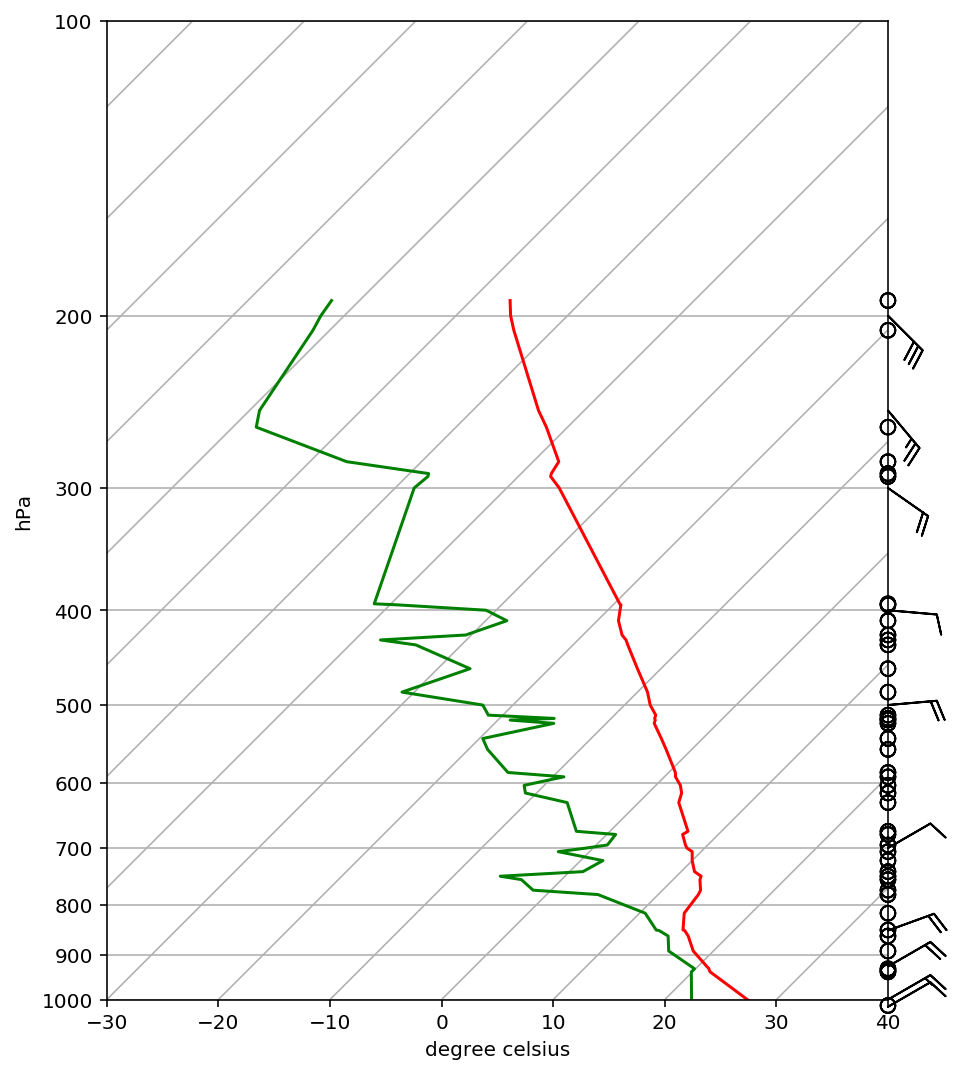

In [58]:
plot_radiosonde(df)